In [19]:
import os
import shutil
import numpy as np
import pandas as pd # Adicionado para o caso de precisarmos no futuro, mas não usado ativamente aqui
from scipy.signal import butter, filtfilt

In [26]:
# --- 1. Definição dos Caminhos Base ---
base_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
processed_data_dir = os.path.join(base_dir, 'data', 'processed')

# --- 2. Definição dos Caminhos de Destino (Output Final) ---
dest_base_dir = os.path.join(processed_data_dir, 'filtrados_e_processado')
dest_af_dir = os.path.join(dest_base_dir, 'AF')
dest_normal_dir = os.path.join(dest_base_dir, 'N')
dest_other_dir = os.path.join(dest_base_dir, 'O')
dest_noise_dir = os.path.join(dest_base_dir, 'RUIDO') # <-- MUDANÇA AQUI

# --- 3. Mapeamento Abrangente de Todas as Fontes para os Destinos ---
data_mapping = {
    dest_af_dir: [
        os.path.join(processed_data_dir, 'classified_ecgs_code15', 'AF'),
        os.path.join(processed_data_dir, 'basededados', 'training2017', 'AF'),
        os.path.join(processed_data_dir, 'basededados', 'validation2017', 'AF')
    ],
    dest_normal_dir: [
        os.path.join(processed_data_dir, 'classified_ecgs_code15', 'NORMAL'),
        os.path.join(processed_data_dir, 'basededados', 'training2017', 'Normal'),
        os.path.join(processed_data_dir, 'basededados', 'validation2017', 'Normal')
    ],
    dest_other_dir: [
        os.path.join(processed_data_dir, 'classified_ecgs_code15', 'OTHER'),
        os.path.join(processed_data_dir, 'basededados', 'training2017', 'Other'),
        os.path.join(processed_data_dir, 'basededados', 'validation2017', 'Other')
    ],
    dest_noise_dir: [ 
        os.path.join(processed_data_dir, 'physionet-noise-d1-npy'),
        os.path.join(processed_data_dir, 'basededados', 'training2017', 'Ruido'),
        os.path.join(processed_data_dir, 'basededados', 'validation2017', 'Ruido'),
        os.path.join(processed_data_dir, 'basededados2', 'ruidos', 'mit-bih-noise-stress-test'),
        os.path.join(processed_data_dir, 'basededados2', 'ruidos', 'motion-artifact-contaminated')
    ]
}

# --- 4. Criação dos Diretórios de Destino ---
print("Verificando e criando a estrutura de diretórios de destino...")
for dest_path in data_mapping.keys():
    os.makedirs(dest_path, exist_ok=True)
print("Estrutura de diretórios pronta.")

Verificando e criando a estrutura de diretórios de destino...
Estrutura de diretórios pronta.


In [23]:
def preprocess_ecg_signal(signal, fs=300, target_length=8000):
    """
    Aplica um pipeline completo de pré-processamento a um sinal de ECG.
    """
    # Etapa 1: Redimensionar para o comprimento alvo (8000 pontos) - JÁ FAZ O PADDING
    current_length = len(signal)
    if current_length > target_length:
        processed_signal = signal[:target_length] # Truncar
    elif current_length < target_length:
        processed_signal = np.pad(signal, (0, target_length - current_length), 'constant') # Zero Padding
    else:
        processed_signal = signal

    # Etapa 2: Aplicar filtro passa-alta (remove baseline wander)
    nyquist = 0.5 * fs
    high_cutoff = 1.0 / nyquist
    b_high, a_high = butter(2, high_cutoff, btype='high', analog=False)
    processed_signal = filtfilt(b_high, a_high, processed_signal)

    # Etapa 3: Aplicar filtro passa-baixa (remove ruído de alta frequência)
    low_cutoff = 30.0 / nyquist
    b_low, a_low = butter(6, low_cutoff, btype='low', analog=False)
    processed_signal = filtfilt(b_low, a_low, processed_signal)

    # Etapa 4: Normalizar para o intervalo [0, 1]
    min_val = np.min(processed_signal)
    max_val = np.max(processed_signal)
    if (max_val - min_val) > 0:
        processed_signal = (processed_signal - min_val) / (max_val - min_val)
    else:
        processed_signal = np.zeros_like(processed_signal)
        
    return processed_signal

In [24]:
print("\n--- Iniciando o Pré-processamento de Todos os Datasets ---")

total_files_processed = 0
for dest_path, source_paths_list in data_mapping.items():
    class_name = os.path.basename(dest_path)
    print(f"\nProcessando dados para a classe final: '{class_name}'")

    for source_path in source_paths_list:
        source_name = os.path.join(os.path.basename(os.path.dirname(source_path)), os.path.basename(source_path))
        print(f"  Lendo de: .../{source_name}")

        if not os.path.exists(source_path):
            print(f"    AVISO: Diretório de origem não encontrado. Pulando.")
            continue
            
        npy_files = [f for f in os.listdir(source_path) if f.endswith('.npy')]
        
        if not npy_files:
            print("    Nenhum arquivo .npy encontrado nesta pasta.")
            continue

        for file_name in npy_files:
            try:
                original_signal = np.load(os.path.join(source_path, file_name))
                final_signal = preprocess_ecg_signal(original_signal)
                
                output_path = os.path.join(dest_path, file_name)
                np.save(output_path, final_signal)
                total_files_processed += 1
                
            except Exception as e:
                print(f"    ERRO ao processar o arquivo {file_name}: {e}")
                
    print(f"  Processamento para a classe '{class_name}' concluído.")

print(f"\n--- Processo Finalizado: {total_files_processed} arquivos foram processados e salvos. ---")


--- Iniciando o Pré-processamento de Todos os Datasets ---

Processando dados para a classe final: 'AF'
  Lendo de: .../classified_ecgs_code15\AF
  Lendo de: .../training2017\AF
  Lendo de: .../validation2017\AF
  Processamento para a classe 'AF' concluído.

Processando dados para a classe final: 'N'
  Lendo de: .../classified_ecgs_code15\NORMAL
  Lendo de: .../training2017\Normal
  Lendo de: .../validation2017\Normal
  Processamento para a classe 'N' concluído.

Processando dados para a classe final: 'O'
  Lendo de: .../classified_ecgs_code15\OTHER
  Lendo de: .../training2017\Other
  Lendo de: .../validation2017\Other
  Processamento para a classe 'O' concluído.

Processando dados para a classe final: 'RUIDO'
  Lendo de: .../processed\physionet-noise-d1-only
    AVISO: Diretório de origem não encontrado. Pulando.
  Lendo de: .../training2017\Ruido
  Lendo de: .../validation2017\Ruido
  Lendo de: .../ruidos\mit-bih-noise-stress-test
  Lendo de: .../ruidos\motion-artifact-contaminated

In [30]:
print("\n--- Contagem Final de Amostras por Classe ---")

class_map = {
    'AF': 'FA (Fibrilação Atrial)',
    'N': 'Normal',
    'O': 'Outros Ritmos',
    'RUIDO': 'Ruído' # <-- MUDANÇA AQUI
}

total_geral = 0
for folder_name, class_description in class_map.items():
    path = os.path.join(dest_base_dir, folder_name)
    if os.path.exists(path):
        count = len([f for f in os.listdir(path) if f.endswith('.npy')])
        print(f"  - Classe {class_description} ({folder_name}): {count} amostras")
        total_geral += count
    else:
        print(f"  - Classe {class_description} ({folder_name}): 0 amostras (diretório não encontrado)")

print("---------------------------------------------")
print(f"  Total de amostras processadas: {total_geral}")


--- Contagem Final de Amostras por Classe ---
  - Classe FA (Fibrilação Atrial) (AF): 7774 amostras
  - Classe Normal (N): 139712 amostras
  - Classe Outros Ritmos (O): 33204 amostras
  - Classe Ruído (RUIDO): 551 amostras
---------------------------------------------
  Total de amostras processadas: 181241


In [52]:
# --- 1. Definição dos Caminhos Base ---
base_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
processed_data_dir = os.path.join(base_dir, 'data', 'processed')

# --- 2. Caminhos das Fontes (Sinais "Limpos" ANTES da filtragem final) ---
source_signal_folders = [
    os.path.join(processed_data_dir, 'classified_ecgs_code15', 'AF'),
    os.path.join(processed_data_dir, 'classified_ecgs_code15', 'NORMAL'),
    os.path.join(processed_data_dir, 'classified_ecgs_code15', 'OTHER'),
    os.path.join(processed_data_dir, 'basededados', 'training2017', 'AF'),
    os.path.join(processed_data_dir, 'basededados', 'training2017', 'Normal'),
    os.path.join(processed_data_dir, 'basededados', 'training2017', 'Other'),
    os.path.join(processed_data_dir, 'basededados', 'validation2017', 'AF'),
    os.path.join(processed_data_dir, 'basededados', 'validation2017', 'Normal'),
    os.path.join(processed_data_dir, 'basededados', 'validation2017', 'Other'),
]

# --- 3. Caminhos de Destino e Contagem ---
final_processed_dir = os.path.join(processed_data_dir, 'filtrados_e_processado')
existing_noise_dir = os.path.join(final_processed_dir, 'RUIDO')
generated_noise_dir = os.path.join(final_processed_dir, 'RUIDO_GERADOS')

# Cria o diretório de destino para o ruído gerado
os.makedirs(generated_noise_dir, exist_ok=True)
print("Diretório para ruído gerado está pronto.")

Diretório para ruído gerado está pronto.


In [53]:
TARGET_COUNT = 4096

if os.path.exists(existing_noise_dir):
    current_noise_count = len([f for f in os.listdir(existing_noise_dir) if f.endswith('.npy')])
else:
    current_noise_count = 0

samples_to_generate = TARGET_COUNT - current_noise_count

print(f"Total de amostras de ruído desejado: {TARGET_COUNT}")
print(f"Amostras de ruído real existentes: {current_noise_count}")
print("-------------------------------------------------")

if samples_to_generate > 0:
    print(f"É necessário gerar {samples_to_generate} novas amostras de ruído artificial.")
else:
    print("O número de amostras de ruído já atingiu ou ultrapassou a meta. Nenhuma amostra será gerada.")

Total de amostras de ruído desejado: 4096
Amostras de ruído real existentes: 551
-------------------------------------------------
É necessário gerar 3545 novas amostras de ruído artificial.


In [54]:
def generate_raw_artificial_noise_with_stitch(base_signal_1, base_signal_2, fs=300):
    """
    Cria um sinal de ruído "cru" costurando dois sinais base e adicionando artefatos.
    """
    # 1. Escolher um ponto de costura aleatório (entre 2000 e 6000 amostras)
    split_point = random.randint(2000, 6000)

    # 2. Pegar segmentos dos dois sinais
    # Garante que não haverá erro se o sinal original for curto
    segment_1 = base_signal_1[:split_point]
    segment_2 = base_signal_2[:(8000 - len(segment_1))] # Pega o que falta para completar aprox. 8000

    # 3. Costurar os segmentos para criar a base caótica
    stitched_signal = np.concatenate([segment_1, segment_2])
    
    # --- O resto da lógica de adicionar ruído permanece a mesma ---
    signal_len = len(stitched_signal)
    noisy_signal = stitched_signal.copy()
    time_points = np.linspace(0, signal_len / fs, signal_len)
    
    # Adicionar Flutuação da Linha de Base
    for _ in range(random.randint(1, 2)):
        freq = random.uniform(0.1, 0.7)
        amplitude = random.uniform(0.1, 0.4) * (np.max(noisy_signal) - np.min(noisy_signal))
        baseline_wander = amplitude * np.sin(2 * np.pi * freq * time_points + random.uniform(0, 2*np.pi))
        noisy_signal += baseline_wander

    # Adicionar Ruído de Alta Frequência
    emg_noise_amplitude = random.uniform(0.05, 0.15) * np.std(noisy_signal)
    emg_noise = np.random.normal(0, emg_noise_amplitude, signal_len)
    noisy_signal += emg_noise
    
    powerline_amplitude = random.uniform(0.05, 0.1) * np.std(noisy_signal)
    powerline_noise = powerline_amplitude * np.sin(2 * np.pi * 60 * time_points)
    noisy_signal += powerline_noise
        
    return noisy_signal

def preprocess_ecg_signal(signal, fs=300, target_length=8000):
    """
    Aplica o pipeline COMPLETO de pré-processamento (padding, filtros, normalização).
    """
    current_length = len(signal)
    if current_length > target_length:
        processed_signal = signal[:target_length]
    elif current_length < target_length:
        processed_signal = np.pad(signal, (0, target_length - current_length), 'constant')
    else:
        processed_signal = signal

    nyquist = 0.5 * fs
    b_high, a_high = butter(2, 1.0 / nyquist, btype='high')
    processed_signal = filtfilt(b_high, a_high, processed_signal)

    b_low, a_low = butter(6, 30.0 / nyquist, btype='low')
    processed_signal = filtfilt(b_low, a_low, processed_signal)

    min_val, max_val = np.min(processed_signal), np.max(processed_signal)
    if (max_val - min_val) > 0:
        processed_signal = (processed_signal - min_val) / (max_val - min_val)
    else:
        processed_signal = np.zeros_like(processed_signal)
        
    return processed_signal

In [55]:
if samples_to_generate > 0:
    print("\n--- Coletando a lista de todos os sinais base (AF, Normal, Other) ---")
    base_signal_paths = []
    for folder in source_signal_folders:
        if os.path.exists(folder):
            for file_name in os.listdir(folder):
                if file_name.endswith('.npy'):
                    base_signal_paths.append(os.path.join(folder, file_name))
    
    if len(base_signal_paths) < 2:
        print("ERRO: Menos de dois sinais base encontrados. Não é possível fazer a costura.")
    else:
        print(f"Total de {len(base_signal_paths)} sinais base encontrados.")
        print(f"\n--- Iniciando a geração e processamento de {samples_to_generate} amostras ---")
        
        for i in range(samples_to_generate):
            try:
                # 1. Escolhe DOIS sinais base aleatórios
                path1, path2 = random.sample(base_signal_paths, 2)
                base_signal_1 = np.load(path1)
                base_signal_2 = np.load(path2)
                
                # 2. Gera o ruído "cru" usando a costura
                raw_noise = generate_raw_artificial_noise_with_stitch(base_signal_1, base_signal_2)
                
                # 3. Aplica o pipeline de processamento final
                final_processed_noise = preprocess_ecg_signal(raw_noise)
                
                # 4. Salva o resultado final
                file_name = f"artificial_noise_{str(i+1).zfill(4)}.npy"
                output_path = os.path.join(generated_noise_dir, file_name)
                np.save(output_path, final_processed_noise)
                
                if (i + 1) % 100 == 0:
                    print(f"  ... {i + 1} / {samples_to_generate} amostras geradas e processadas.")
                    
            except Exception as e:
                print(f"ERRO ao gerar a amostra {i+1}: {e}")

        print("\n--- Geração e Processamento Concluídos! ---")
        final_count = len(os.listdir(generated_noise_dir))
        print(f"Total de {final_count} arquivos foram salvos em .../{os.path.basename(generated_noise_dir)}/")


--- Coletando a lista de todos os sinais base (AF, Normal, Other) ---
Total de 180946 sinais base encontrados.

--- Iniciando a geração e processamento de 3545 amostras ---
  ... 100 / 3545 amostras geradas e processadas.
  ... 200 / 3545 amostras geradas e processadas.
  ... 300 / 3545 amostras geradas e processadas.
  ... 400 / 3545 amostras geradas e processadas.
  ... 500 / 3545 amostras geradas e processadas.
  ... 600 / 3545 amostras geradas e processadas.
  ... 700 / 3545 amostras geradas e processadas.
  ... 800 / 3545 amostras geradas e processadas.
  ... 900 / 3545 amostras geradas e processadas.
  ... 1000 / 3545 amostras geradas e processadas.
  ... 1100 / 3545 amostras geradas e processadas.
  ... 1200 / 3545 amostras geradas e processadas.
  ... 1300 / 3545 amostras geradas e processadas.
  ... 1400 / 3545 amostras geradas e processadas.
  ... 1500 / 3545 amostras geradas e processadas.
  ... 1600 / 3545 amostras geradas e processadas.
  ... 1700 / 3545 amostras geradas 

Plotando uma amostra aleatória final: artificial_noise_3262.npy


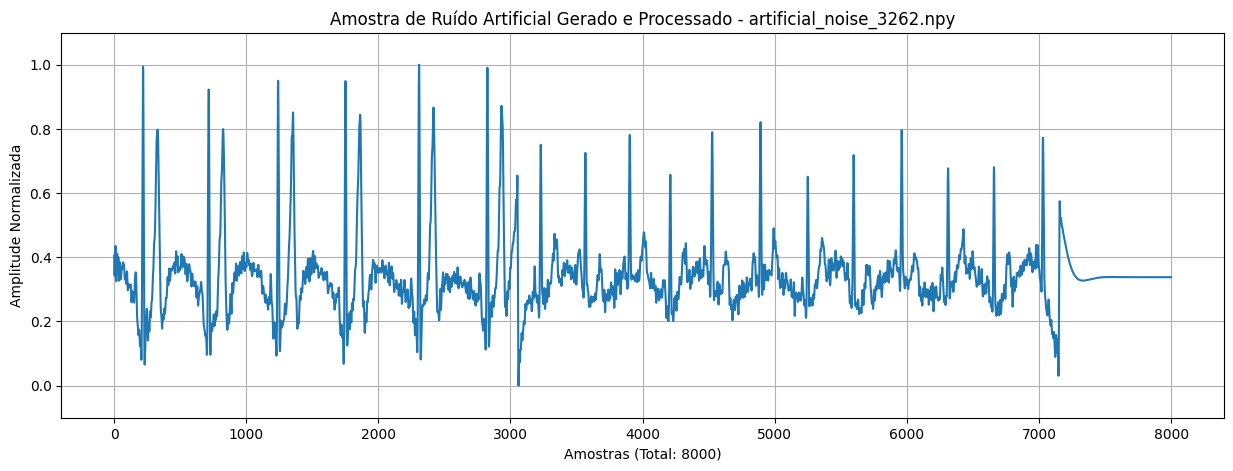

In [ ]:
if os.path.exists(generated_noise_dir) and len(os.listdir(generated_noise_dir)) > 0:
    random_noise_file = random.choice(os.listdir(generated_noise_dir))
    noise_path = os.path.join(generated_noise_dir, random_noise_file)
    
    sample_noise = np.load(noise_path)
    
    print(f"Plotando uma amostra aleatória final: {random_noise_file}")
    
    plt.figure(figsize=(15, 5))
    plt.plot(sample_noise)
    plt.title(f'Amostra de Ruído Artificial Gerado e Processado - {random_noise_file}')
    plt.xlabel('Amostras (Total: 8000)')
    plt.ylabel('Amplitude Normalizada')
    plt.ylim(-0.1, 1.1)
    plt.grid(True)
    plt.show()